# Evaluating a Modern Polish POS-Tagger on Historical Data
### by Maria Irena Szawerna

### IMPORTS, VARIABLES, AND PARAMETERS

In [1]:
import requests
import math
import sklearn.metrics
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

pd.set_option('display.max_rows', None)

In [2]:
# from https://cloud.gate.ac.uk/shopfront/displayItem/tagger-pos-pl-maxent1 - "A POS tagger for pl / Polish using the Universal 
# Dependencies POS tagset.
# instructions on how to use the API from https://cloud.gate.ac.uk/info/help/online-api.html

URL = 'https://cloud-api.gate.ac.uk/process/tagger-pos-pl-maxent1'
PARAMS = {
    'Content-Type': 'text/plain',
    'Accept': 'application/json'
}
file = 'memoirs_annotated_3k.txt'

### FUNCTIONS AND CLASSES

In [3]:
def retrieve_text(filename: str):
    '''A function intended for opening and reading a text file, with lines being stripped of leading and trailing whitespace.
    
    Args:
        filename (str): The name of the file or path to the file that is to be opened.
        
    Returns:
        A list of strings representing the lines in the file, stripped of whitespace on the edges.
    '''
    with open(filename) as f:
        lines = f.readlines()
        
        all_lines = []
        for line in lines:
            all_lines.append(line.strip())
        return all_lines

In [4]:
class OriginalAnnotations:
    '''A class intended to process and store the tokens and their respective annotations from the original text.
    
    Attributes:
        tokens (list[str]): A list of all the tokens (without annotation) in the original data. Every element of the list is a string.
        gold_standard (list[str]): A list of all the original annotations (without tokens). Every element is a string.
    '''
    def __init__(self, data: list, lowercase: bool = False):
        '''The __init__ method of the class.
        Constructs the token and gold_standard lists.
        
        Args:
            data (list[str]): A list of annotated sentences. Every element of the list is a string representing the whole sentence.
            lowercase (bool): Determines whether the tokens should be lowercased or if original capitalization should be retained.
        '''
        self.tokens = []
        self.gold_standard = []
        
        for sentence in text:
            sentence.strip()
            sentence = sentence.split(" ")
            for annotated_token in sentence:
                if annotated_token[0] == '[':
                    annotated_token = annotated_token[1:]
                if annotated_token[-1] == ']':
                    annotated_token = annotated_token[:-1]
                split_token = annotated_token.split('_')
                if not lowercase:
                    self.tokens.append(split_token[0])
                else:
                    self.tokens.append(split_token[0].lower())
                self.gold_standard.append(split_token[1])
                
    def __len__(self):
        '''The __len__ magic method of the class.
            
        Returns:
            The length of self.tokens, which should be identical to the length of self.gold_standard.
        '''
        return len(self.tokens)
        
    def __getitem__(self, index: int):
        '''The __getitem__ magic method of the class.
            
        Args:
            index (int): The index signifying the desired element.
            
        Returns:
            A string representing the combination of the original token and annotation.
        '''
        token = self.tokens[index]
        annotation = self.gold_standard[index]
        item = '_'.join([token, annotation])
            
        return item

In [5]:
class TaggerAnnotations:
    '''A class intended for retrieving, processing, and storing the annotations from an online tagger.
    
    Attributes:
        processed_annotations (list[list]): A list of lists, every element of which represents a number of values returned by the
            tagger. The values include the token, the POS tag, the confidence thereof, a list of possible targets and a list
            of those confidences.
        only_annotations (list[str]): A list containing only the POS tags obtained from the tagger.    
    '''
    def __init__(self, url: str, headers: dict, data: list):
        '''The __init__ method of the class.
        Retrieves the tagger annotations (in batches, if needed), constructs processed_annotations and only_annotations using
        the __retrieve_anns method.
        
        Args:
            url (str): The URL to which the query should be made.
            headers (dict): The parameters that the query requires.
            data (list[str]): The original, unannotated data represented as a list of individual tokens (not sentences).        
        '''
        self.processed_annotations = []
        self.only_annotations = []
        
        if len(data) > 1000:  # this is required due to the tagger bottleneck
            prev_i = 0
            for i in range(1, math.floor(len(data)/1000)):
                subset = data[prev_i*1000:i*1000]
                prev_i = i
                subset = ' '.join(subset)
                r = requests.post(url=url, data=subset.encode('utf-8'), headers=headers)
                annotations = r.json()
                for entry in tqdm(annotations['entities']['Token'], desc='Loading annotations...'):
                    self.__retrieve_anns(entry)
                    
            subset = data[prev_i*1000:]
            subset = ' '.join(subset)
            r = requests.post(url=url, data=subset.encode('utf-8'), headers=headers)
            annotations = r.json()
            for entry in tqdm(annotations['entities']['Token'], desc='Loading annotations...'):
                self.__retrieve_anns(entry)        
            
        
        else:
            data = ' '.join(data)

            r = requests.post(url=url, data=data.encode('utf-8'), headers=headers) 
            self.annotations = r.json()

            for entry in tqdm(annotations['entities']['Token'], desc='Loading annotations...'):
                self.__retrieve_anns(entry)

    def print_annotations(self):
        '''A method of the class which prints out all words with their annotation and the confidence thereof.
        '''
        for entry in self.processed_annotations:
            print(entry[0] + ' | ' + entry[1] + ' | ' + str(entry[2]))
            
    def __retrieve_anns(self, entry: dict):
        '''A method of the class which reads the data returned by the tagger and stores the relevant elements in appropriate
        lists.
        
        Args:
            entry (dict): An entry returned by the tagger.
        '''
        word = entry['string']
        pos = entry['upos']
        confidence = entry['LF_confidence']
        target_list = entry['LF_target_list']
        confidence_list = entry['LF_confidence_list']

        annotation = [word, pos, confidence, target_list, confidence_list]
        self.processed_annotations.append(annotation)
        self.only_annotations.append(pos)
        
    def __len__(self):
        '''The __len__ magic method of the class.
            
        Returns:
            The length of self.only_annotations, which should be identical to the length of self.processed_annotations.
        '''
        return len(self.only_annotations)
        
    def __getitem__(self, index: int):
        '''The __getitem__ magic method of the class.
            
        Args:
            index (int): The index signifying the desired element.
            
        Returns:
            A string representing the combination of the original token and the tagger annotation.
        '''
        full_ann = self.processed_annotations[index]
        token = full_ann[0]
        annotation = full_ann[1]
        item = '_'.join([token, annotation])
            
        return item
        

In [6]:
def get_measures(gold_standard: list, predictions: list):
    '''A function intended for retrieving a selection of evaluation measures for comparing the gold standard and the tagger
    annotations. The measures are printed out and include accuracy, Matthew's Correlation Coefficient, per-class precision 
    and recall, as well as a confusion matrix, which, in addition, get saved locally. These measures are calculated using 
    functions from sklearn and pyplot.
    
    Args:
        gold_standard (list[str]): A list of gold standard labels.
        predictions (list[str]): A list of predicted labels.
    '''
    labels = sorted(list(set(gold_standard)))
    print('MEASURES:')
    print(f'Accuracy: {"{:.2%}".format(sklearn.metrics.accuracy_score(gold_standard, predictions))}')
    print(f'Matthew\'s Correlation Coefficient: {"{:.2%}".format(sklearn.metrics.matthews_corrcoef(gold_standard, predictions))}')
    print()
    print('MEASURES PER CLASS:')
    precision = sklearn.metrics.precision_score(gold_standard, predictions, average=None, labels=labels)
    print('Precision:')
    for i in range(0,len(labels)):
        print(f'\t{labels[i]}: {"{:.2%}".format(precision[i])}')
    recall = sklearn.metrics.recall_score(gold_standard, predictions, average=None, labels=labels)
    print('Recall:')
    for i in range(0,len(labels)):
        print(f'\t{labels[i]}: {"{:.2%}".format(recall[i])}')
    print()
    print('Confusion matrix:')
    cm = sklearn.metrics.confusion_matrix(gold_standard, predictions)
    matrix = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(12,12))
    matrix.plot(ax=ax)
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig("./images/" + timestr + "confusion_matrix.jpg")
    

In [7]:
def get_problematic_anns(
    gold_standard: list, 
    predictions: list, 
    processed_annotations: list, 
    tokens: list
):
    '''A function intended for collecting the wrong annotations from the tagger and storing them in a DataFrame with the 
    original token, context, gold standard, prediction, and the confidence of that prediction.
    
    Args:
        gold_standard (list[str]): A list of gold standard tags represented as strings.
        predictions (list[str]): A list of predicted tags represented as strings.
        processed_annotations (list[list]): A list of lists where every element represents information about the annotation as
            obtained from the tagger.
        tokens (list[str]): A list of the original tokens.
        
    Returns:
        A DataFrame containing the original token, context, gold standard, prediction, and the confidence of that prediction 
        for every mismatched prediction and gold standard.
    '''
    problematic = []
    for i in range(0, len(tokens)):
        
        if gold_standard[i] != predictions[i]:
            if i != 0:
                preceding = tokens[i-1]
            else:
                preceding = ''
                
            if i != len(tokens)-1:
                succeeding = tokens[i+1]
            else:
                succeeding = ''
                
            problematic.append(
                (tokens[i], 
                 ' '.join([preceding, tokens[i], succeeding]), 
                 gold_standard[i], 
                 predictions[i], 
                 processed_annotations[i][2])
            )
            
    problematic_frame = pd.DataFrame(problematic, columns=['Token', 'Context', 'Gold Standard', 'Prediction', 'Confidence'])
    
    return problematic_frame

### RESULTS (non-lowercase)

In [8]:
# retrieving the lines from the annotated file
text = retrieve_text(file)

In [9]:
# creating an OriginalAnnotations object to store the tokens and original annotations
original_text = OriginalAnnotations(text)

In [10]:
# creating a TaggerAnnotations object to retrieve and store tagger annotations
tagger_anns = TaggerAnnotations(URL, PARAMS, original_text.tokens)

Loading annotations...: 100%|███████████████████████████████████████████████████| 1270/1270 [00:00<00:00, 514514.25it/s]


In [11]:
# sanity check
for i in range(0,len(tagger_anns.processed_annotations)):
    if tagger_anns.processed_annotations[i][0] != original_text.tokens[i]:
        print(f'mismatch at {i}: {tagger_anns.processed_annotations[i][0]} and {original_text.tokens[i]}')
        print()

MEASURES:
Accuracy: 83.98%
Matthew's Correlation Coefficient: 81.82%

MEASURES PER CLASS:
Precision:
	ADJ: 61.51%
	ADP: 95.65%
	ADV: 72.29%
	AUX: 76.92%
	CCONJ: 97.52%
	DET: 98.46%
	NOUN: 84.94%
	NUM: 73.68%
	PART: 82.22%
	PRON: 82.89%
	PROPN: 66.23%
	PUNCT: 100.00%
	SCONJ: 80.43%
	VERB: 84.40%
	X: 64.52%
Recall:
	ADJ: 78.90%
	ADP: 97.06%
	ADV: 70.59%
	AUX: 74.63%
	CCONJ: 95.73%
	DET: 42.11%
	NOUN: 79.56%
	NUM: 65.12%
	PART: 59.68%
	PRON: 88.73%
	PROPN: 93.09%
	PUNCT: 100.00%
	SCONJ: 53.62%
	VERB: 90.38%
	X: 52.63%

Confusion matrix:


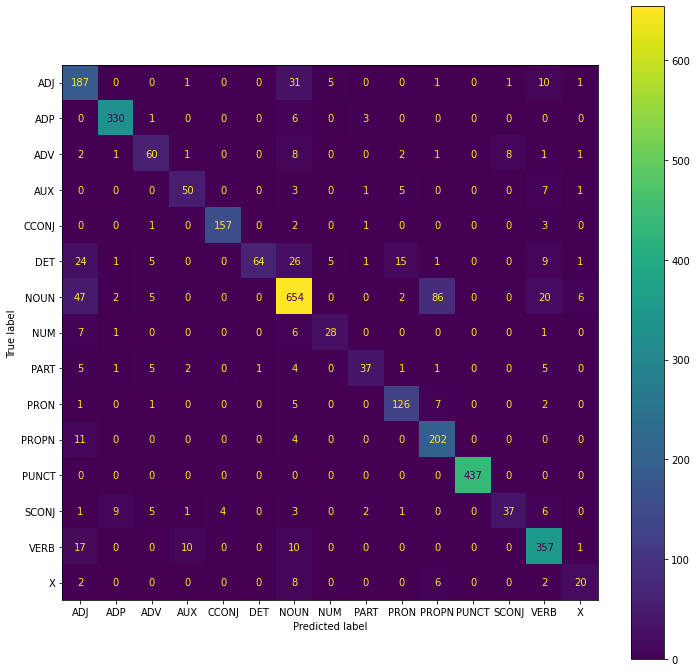

In [12]:
# evaluating the tagger annotations
get_measures(original_text.gold_standard, tagger_anns.only_annotations)

In [13]:
# constructing a frame containing problematic annotations
frame = get_problematic_anns(
    original_text.gold_standard, 
    tagger_anns.only_annotations, 
    tagger_anns.processed_annotations, 
    original_text.tokens
)

In [14]:
# printing out the frame
frame

,Token,Context,Gold Standard,Prediction,Confidence
0,syn,Rypnin syn komornika,NOUN,ADP,0.446107
1,Komornika,Jana Komornika ziemi,NOUN,PROPN,0.967253
2,ziemi,Komornika ziemi Dobrrzyńskiej,NOUN,VERB,0.494722
3,właścicieli,Pinińskich właścicieli Dóbr,NOUN,VERB,0.440838
4,Dóbr,właścicieli Dóbr Strużewo,NOUN,PROPN,0.997932
5,śp,że śp Dziad,X,NOUN,0.792097
6,Dziad,śp Dziad mój,NOUN,PROPN,0.780149
7,mój,Dziad mój był,DET,VERB,0.513002
8,najmłodszy,był najmłodszy i,ADJ,NOUN,0.540951
9,piąty,i piąty z,ADJ,NOUN,0.875564


In [15]:
# printing out the frame sorted by gold standard values
frame.sort_values('Gold Standard')

,Token,Context,Gold Standard,Prediction,Confidence
261,najlepsze,Długim najlepsze mają,ADJ,NOUN,0.779396
317,urzędowey,manipulacyi urzędowey –,ADJ,NOUN,0.806289
311,ludowemi,dziś ludowemi zwanych,ADJ,NOUN,0.679568
289,urzędowa,pieczęć urzędowa jurysdykcyi,ADJ,NOUN,0.769623
285,dziesiąty,jest dziesiąty pniak,ADJ,NOUN,0.718796
279,uwolnieni,poddani uwolnieni za,ADJ,NOUN,0.618777
271,Oycowskiey,. Oycowskiey .,ADJ,X,0.552563
266,suchey,morgów suchey łąki,ADJ,NOUN,0.575101
264,ciągła,robota ciągła do,ADJ,VERB,0.974589
239,pierwszey,policyjną pierwszey instantacyi,ADJ,NOUN,0.860056


### RESULTS (lowercase)

In [16]:
# creating an OriginalAnnotations object to store the tokens and original annotations, in lowercase
original_lowercase = OriginalAnnotations(text, lowercase=True)

In [17]:
# creating a TaggerAnnotations object to retrieve and store tagger annotations for lowercase tokens
tagger_lowercase = TaggerAnnotations(URL, PARAMS, original_lowercase.tokens)

Loading annotations...: 100%|███████████████████████████████████████████████████| 1270/1270 [00:00<00:00, 483372.60it/s]


In [18]:
# sanity check
for i in range(0,len(tagger_lowercase.processed_annotations)):
    if tagger_lowercase.processed_annotations[i][0] != original_lowercase.tokens[i]:
        print(f'mismatch at {i}: {tagger_lowercase.processed_annotations[i][0]} and {original_lowercase.tokens[i]}')
        print()

/home/turtilla/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MEASURES:
Accuracy: 80.46%
Matthew's Correlation Coefficient: 77.80%

MEASURES PER CLASS:
Precision:
	ADJ: 52.56%
	ADP: 95.94%
	ADV: 70.11%
	AUX: 73.91%
	CCONJ: 97.50%
	DET: 98.67%
	NOUN: 73.23%
	NUM: 69.44%
	PART: 82.61%
	PRON: 83.12%
	PROPN: 0.00%
	PUNCT: 100.00%
	SCONJ: 77.50%
	VERB: 82.45%
	X: 64.00%
Recall:
	ADJ: 78.06%
	ADP: 97.35%
	ADV: 71.76%
	AUX: 76.12%
	CCONJ: 95.12%
	DET: 48.68%
	NOUN: 89.54%
	NUM: 58.14%
	PART: 61.29%
	PRON: 93.66%
	PROPN: 0.00%
	PUNCT: 100.00%
	SCONJ: 44.93%
	VERB: 90.38%
	X: 42.11%

Confusion matrix:


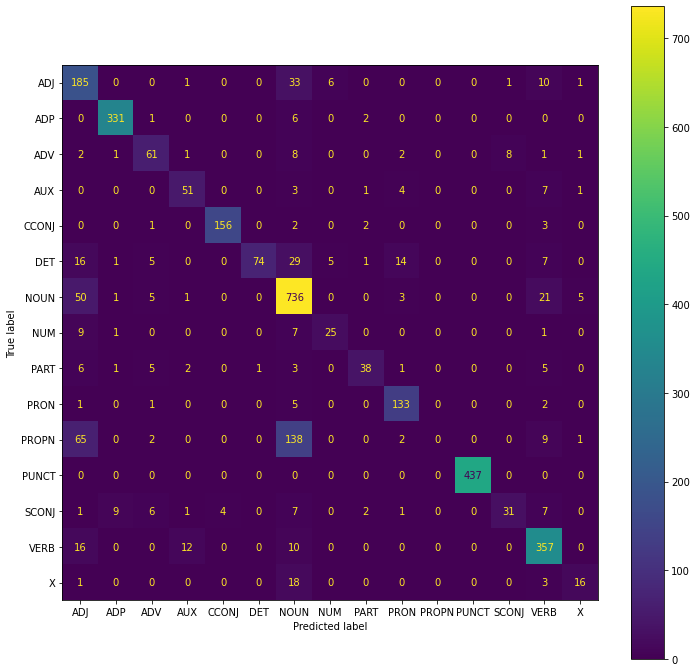

In [19]:
# evaluating the tagger annotations on lowercase tokens
get_measures(original_lowercase.gold_standard, tagger_lowercase.only_annotations)

In [20]:
# constructing a frame containing problematic annotations for lowercase tokens
frame_lower = get_problematic_anns(
    original_lowercase.gold_standard, 
    tagger_lowercase.only_annotations, 
    tagger_lowercase.processed_annotations, 
    original_lowercase.tokens
)

In [21]:
# printing out the frame
frame_lower

,Token,Context,Gold Standard,Prediction,Confidence
0,melchior,mój melchior urodzony,PROPN,NOUN,0.942520
1,godziszewo,wsi godziszewo parafii,PROPN,NOUN,0.760044
2,rypnin,parafii rypnin syn,PROPN,ADJ,0.428394
3,jana,ziemskiego jana komornika,PROPN,NOUN,0.964110
4,dobrrzyńskiej,ziemi dobrrzyńskiej (,PROPN,ADJ,0.963340
5,antoniego,nie antoniego –,PROPN,ADJ,0.959326
6,antoni,– antoni był,PROPN,NOUN,0.447708
7,melchiora,. melchiora –,PROPN,NOUN,0.935199
8,ewy,matki ewy z,PROPN,VERB,0.682664
9,pinińskich,z pinińskich właścicieli,PROPN,ADJ,0.818350


In [22]:
# printing out the frame sorted by gold standard values
frame_lower.sort_values('Gold Standard')

,Token,Context,Gold Standard,Prediction,Confidence
542,gołey,na gołey podłodze,ADJ,NOUN,0.732511
473,szyzmatycki,pop szyzmatycki jako,ADJ,NOUN,0.514451
602,odległey,mil odległey od,ADJ,NOUN,0.381790
169,starsi,. starsi bracia,ADJ,NOUN,0.395832
344,oycowskiey,. oycowskiey .,ADJ,X,0.399155
207,poczciwa,moja poczciwa kobiecina,ADJ,NOUN,0.485883
439,szerokie,płótno szerokie bielone,ADJ,AUX,0.461426
595,młodą,piękną młodą żoneczką,ADJ,NOUN,0.947394
364,urzędowa,pieczęć urzędowa jurysdykcyi,ADJ,NOUN,0.769623
440,grube,bielone grube po,ADJ,NOUN,0.924515
